<a href="https://colab.research.google.com/github/sthuy9804/cmse381-final-project/blob/main/ProjectTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMSE 381 Final Project Template

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

**Sarah***: Work on filling out project template as much as possible, Confusion Matrix per question 3
**Thuy***: Split the files into X and Y, work on the SVM model per question 4
SELF DUE DATE: APRIL 7TH, meet in person, in wells hall

Both: Work on K-Fold and subset selection per question 5

#### CMSE 381 Final Project
### &#9989; Group members: Sarah Horan, Thuy Nguyen
### &#9989; Section_001
#### &#9989; 3/31/25

# ___PREDICTING FACE ORIETATION___

## Background and Motivation

How does the brain recognize not just who we’re looking at, but how they’re positioned in space? This question lies at the intersection of neuroscience and data science. In this project, we investigate how neurons in the anterior medial (AM) face patch of a macaque monkey respond when the animal views faces from different orientations. This brain region is known to be selective for facial features, and here we test whether its activity can reveal not just the presence of a face, but the **direction it's facing**.

The dataset we’re using comes from a study where a monkey passively viewed face images from 25 individuals, each shown in 8 different head orientations. For each image, researchers recorded binary neural spike data across a short time window (0–400 ms) following the image onset.

Our main goal is to explore whether we can **predict the orientation of a viewed face**—such as frontal, profile, or turned head—based on this neural activity alone. This is a classic example of a **neural decoding** task, where machine learning models are trained to extract meaning from complex biological signals.

Specifically, we aim to answer:
- **Can we classify face orientation based on patterns in neural spike data?**

By addressing these questions, we hope to gain insight into how the brain encodes spatial information about faces—and demonstrate how data science tools can uncover patterns in neural data that may not be obvious at first glance.


## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

In [ ]:
import pandas as pd
import numpy as np
import glob
import zipfile
import io
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
from scipy.stats import uniform

# ML imports we've used previously
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# For today, we just need SVC
# from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data
* Describe the data you are using
* What variables are you using?: time spike data
    * What they mean?: the spike of AM when a part of the face showed up
    * Why did you choose them?: want to predict the orientation of the face. Each face reacts differently (need citation)

In [ ]:
zip_path = '/content/drive/MyDrive/Colab_Notebooks/Sec001_Freiwald_Tsao_faceviews_AM_data_csv.zip'

X = []
y = []
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
    spike_data = []
    label_ref = []
    for csv in csv_files:
        with zip_file.open(csv) as file:
            df = pd.read_csv(file)
            spike_cols = [col for col in df.columns if col.startswith('time')]
            spike_data.append(df[spike_cols])
            label_ref.append(df[['labels.orientation']])
X = pd.concat(spike_data)
y = pd.concat(label_ref)

In [ ]:
# Drop rows with NaNs in X and reset index
X = X.dropna().reset_index(drop=True)

# Do the same for y to keep it aligned
y = y.reset_index(drop=True)
y = y.values.ravel()  # Convert to 1D numpy array

In [ ]:
print(X.shape)
X

(206216, 800)


,time.1_2,time.2_3,time.3_4,time.4_5,time.5_6,time.6_7,time.7_8,time.8_9,time.9_10,time.10_11,...,time.791_792,time.792_793,time.793_794,time.794_795,time.795_796,time.796_797,time.797_798,time.798_799,time.799_800,time.800_801
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206213,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(y.shape)
y

(206216,)


array(['front', 'front', 'front', ..., 'back', 'back', 'back'],
      dtype=object)

In [ ]:
y_series = pd.Series(y)

# Recode labels into new groups
def simplify_orientation(label):
    if 'left' in label:
        return 'left'
    elif 'right' in label:
        return 'right'
    elif label in ['front', 'back']:
        return 'frontal'
    else:
        return 'vertical'

y = y_series.apply(simplify_orientation)

from collections import Counter
print(Counter(y))

Counter({'right': 51818, 'frontal': 51715, 'left': 51346, 'vertical': 51337})


In [ ]:
# X = X.iloc[:, :400]
# print(X.shape)
# X

### Pre-processing

The Short-Time Fourier Transform (STFT), Discrete Wavelet Transform (DWT), and Wavelet
Transform (WT) and are time-frequency-based techniques have been used for feature
extraction [65]. These techniques help accurately classify signals by extracting relevant
information. DWT is used to statistically evaluate the frequency bands of medical brain waves,
disclosing signal characteristics in both temporal and frequency domains [67]. The outcome
also demonstrates that most algorithms have performed better when dealing with feature sets
produced by wavelets [2]. Furthermore, Fast Fourier Transform (FFT) focuses primarily on
filtering techniques and divides the time domain into four frequency bands called alpha, beta,
gamma, and delta. It can transform time-domain signals into frequency-domain impulses as
well [68].

Although the methods mentioned can be helpful in most datasets, recent research papers have
indicated that with bigger data sets, Principal Component Analysis (PCA) has a slight
advantage [2]. PCA is considered a feature extraction technique and a dimensionality reduction
method. It will be introduced in the dimensionality reduction section.

In [ ]:
# import pywt

# # Choose wavelet and decomposition level
# wavelet = 'db4'   # Daubechies 4 – good for spike/EEG data
# level = 4         # Number of levels to decompose

# # Apply DWT row-by-row, flatten coefficients into 1D feature vector
# X_dwt = np.array([
#     np.hstack(pywt.wavedec(row, wavelet=wavelet, level=level))
#     for row in X.values
# ])

# print("Original X shape:", X.shape)
# print("DWT-transformed X shape:", X_dwt.shape)

In [ ]:
# from scipy.signal import stft

# # Apply STFT to one row — we'll batch this below
# f, t, Zxx = stft(X.iloc[0], nperseg=64)

# # Convert magnitude to feature vector
# stft_features = np.abs(Zxx).flatten()
# print("STFT features (1 sample):", stft_features.shape)

# X_stft = np.array([
#     np.abs(stft(row, nperseg=64)[2]).flatten()
#     for row in X.values
# ])
# print("STFT-transformed shape:", X_stft.shape)

In [ ]:
# # reduce each first before combining
# X_dwt_pca = PCA(n_components=100).fit_transform(X_dwt)
# X_stft_pca = PCA(n_components=100).fit_transform(X_stft)

# X_features = np.hstack([X_dwt, X_stft])
# X_features.shape

In [ ]:
# pca = PCA(n_components=400)
# X_features = pca.fit_transform(X)

# print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

### Models for classification _(if applicable)_
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [ ]:
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
cv_scores = cross_val_score(logreg, X_train_scale, y_train, cv=5, n_jobs=-1)
logreg.fit(X_train_scale, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = logreg.predict(X_test_scale)

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", np.mean(cv_scores))
test_acc = accuracy_score(y_test, y_pred)
print("Testing accuracy:", test_acc)

from sklearn.metrics import top_k_accuracy_score

# Get class probabilities from the model
y_proba = logreg.predict_proba(X_test)
top1 = top_k_accuracy_score(y_test, y_proba, k=1)
top3 = top_k_accuracy_score(y_test, y_proba, k=3)

print("Logistic Regression Top-1 Accuracy:", round(top1, 4))
print("Logistic Regression Top-3 Accuracy:", round(top3, 4))

print("Classification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.2567282  0.25313474 0.25278836 0.25649463 0.25642536]
Average CV accuracy: 0.25511425889709194
Testing accuracy: 0.25680109916754223


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Logistic Regression Top-1 Accuracy: 0.2537
Logistic Regression Top-3 Accuracy: 0.753
Classification Report:
               precision    recall  f1-score   support

     frontal       0.25      0.19      0.22     15424
        left       0.25      0.18      0.21     15476
       right       0.25      0.47      0.33     15586
    vertical       0.27      0.18      0.22     15379

    accuracy                           0.26     61865
   macro avg       0.26      0.26      0.24     61865
weighted avg       0.26      0.26      0.24     61865



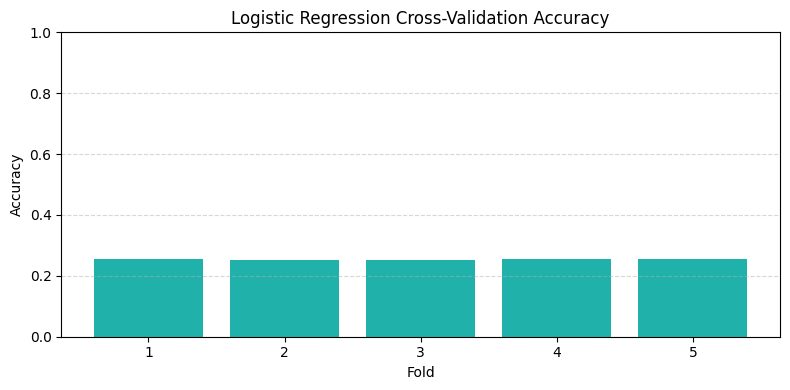

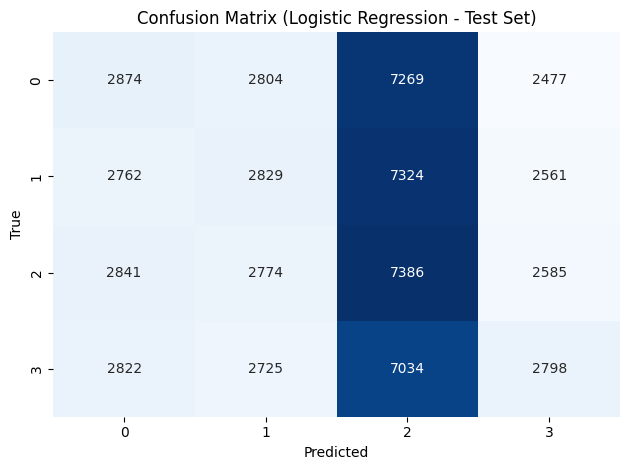

In [ ]:
#Plots
plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='lightseagreen')
plt.ylim(0, 1)
plt.title("Logistic Regression Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Logistic Regression - Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Other methods used _(if applicable)_

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# # Encode string labels to integers
# le = LabelEncoder()
# y_train_encoded = le.fit_transform(y_train)
# y_test_encoded = le.transform(y_test)

# # Now apply one-hot encoding
# y_train_cat = to_categorical(y_train_encoded, num_classes=4)
# y_test_cat = to_categorical(y_test_encoded, num_classes=4)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # This transforms labels to integers (0 to N-1)
y_test_encoded = le.transform(y_test)

# Make sure the labels are integer-encoded
print(np.unique(y_train_encoded))  # [0, 1, 2, 3] for 4 classes

[0 1 2 3]


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Reshape for 1D CNN input: (samples, time steps, channels)
# X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
# X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

# print("Input shape for CNN:", X_train_cnn.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAvgPool1D, BatchNormalization, Dropout, Dense
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(4, activation='softmax')
])

from focal_loss import SparseCategoricalFocalLoss

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss=SparseCategoricalFocalLoss(gamma=2.0),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from focal_loss import SparseCategoricalFocalLoss

# Learning rate schedule
lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=10000)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Metrics
top3_acc = SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy")

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Compile model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalFocalLoss(gamma=2),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        top3_acc
    ]
)

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Fit model
history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.2526 - loss: 1.3551 - top_3_accuracy: 0.7515 - val_accuracy: 0.2552 - val_loss: 0.8833 - val_top_3_accuracy: 0.7593 - learning_rate: 9.2174e-04
Epoch 2/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2557 - loss: 0.8569 - top_3_accuracy: 0.7527 - val_accuracy: 0.2565 - val_loss: 0.8157 - val_top_3_accuracy: 0.7554 - learning_rate: 7.1147e-04
Epoch 3/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2569 - loss: 0.8164 - top_3_accuracy: 0.7557 - val_accuracy: 0.2584 - val_loss: 0.8038 - val_top_3_accuracy: 0.7523 - learning_rate: 4.3500e-04
Epoch 4/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2586 - loss: 0.8041 - top_3_accuracy: 0.7546 - val_accuracy: 0.2559 - val_loss: 0.8004 - val_top_3_accuracy: 0.7612 - learning_rate: 1.7887e-04
Epoch 5/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2729 - loss: 0.7976 - top_3_accuracy: 0.7683 - val_accuracy: 0.2567 - val_loss: 0.7

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2566 - loss: 0.7981 - top_3_accuracy: 0.7558
Test Loss: 0.7979
Top-1 Accuracy: 0.2576
Top-3 Accuracy: 0.7584


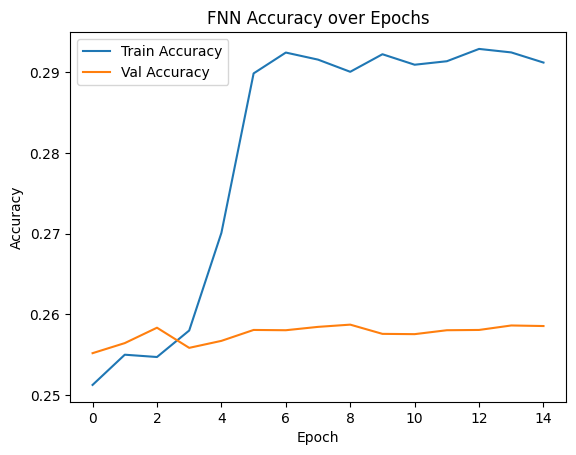

In [ ]:
test_loss, test_acc, test_top3_acc = model.evaluate(X_test_scaled, y_test_encoded)
print("Test Loss:", round(test_loss, 4))
print("Top-1 Accuracy:", round(test_acc, 4))
print("Top-3 Accuracy:", round(test_top3_acc, 4))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("FNN Accuracy over Epochs")
plt.show()

              precision    recall  f1-score   support

     frontal       0.25      0.70      0.37     15424
        left       0.25      0.00      0.01     15476
       right       0.26      0.07      0.11     15586
    vertical       0.27      0.26      0.27     15379

    accuracy                           0.26     61865
   macro avg       0.26      0.26      0.19     61865
weighted avg       0.26      0.26      0.19     61865



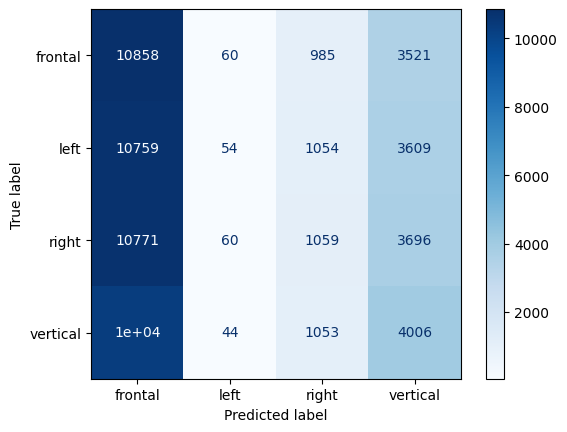

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Map those indices back to labels (if needed)
index_to_label = ['frontal', 'left', 'right', 'vertical']
y_pred_labels = [index_to_label[i] for i in y_pred_indices]

print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_labels, labels=['frontal', 'left', 'right', 'vertical'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['frontal', 'left', 'right', 'vertical'])
disp.plot(cmap='Blues')

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Predict class probabilities
# y_pred_indices = np.argmax(model.predict(X_test_cnn), axis=1)

# # Map predicted indices back to original label names
# index_to_label = ['back', 'down', 'front', 'left 3/4', 'left profile', 'right 3/4', 'right profile', 'up']
# y_pred_labels = [index_to_label[i] for i in y_pred_indices]

# # If y_test is encoded, decode it back to labels using LabelEncoder
# # Otherwise skip this line if y_test already has string labels
# # y_test_labels = label_encoder.inverse_transform(y_test)

# # Confusion matrix using full 8-class label list
# cm = confusion_matrix(y_test, y_pred_labels, labels=index_to_label)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=index_to_label)
# disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
# # merge X_train y_train into 1 dataset
# train_data = pd.DataFrame(X_train_scaled)
# train_data['label'] = y_train

# # sample 50000 random points from train_data
# train_sub = train_data.sample(n=50000, random_state=42)

# # Split into X and y
# X_sub = train_sub.drop(columns='label')
# y_sub = train_sub['label']

# print("X_sub shape:", X_sub.shape)
# print("y_sub shape:", y_sub.shape)

In [ ]:
# p = X_sub.shape[1]

# m_list = [int(np.sqrt(p)), int(p/2), int(p)]
# print('m_list:', m_list)

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [10, 20, None],
#     'max_features': m_list,
#     'n_estimators': [50, 100, 150],
# }

# rf = RandomForestClassifier(n_jobs=-1, random_state=42)
# grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid.fit(X_sub, y_sub)

# print("Best Params:", grid.best_params_)
# print("Best CV Score:", round(grid.best_score_, 4))

m_list: [20, 200, 400]


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

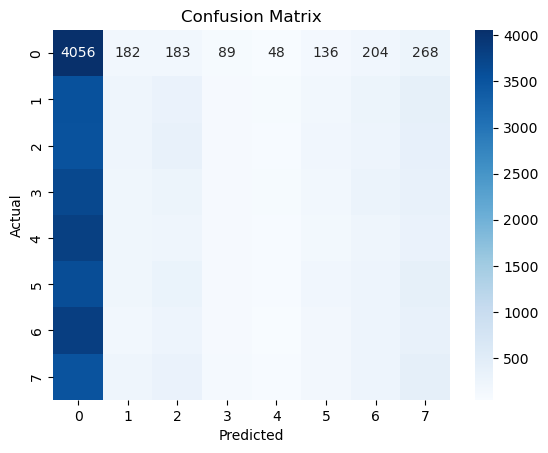

In [ ]:
# y_pred = random_forest.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
# # train and test on real data - not subset of data anymore
# random_forest = RandomForestClassifier(max_features=best_params['max_features'], n_estimators = best_params['n_estimators'], n_jobs=-1, max_depth=20)
# random_forest.fit(X_train, y_train)
# print("Training error with the best hyperparameters:", round(1 - accuracy_score(y_train, random_forest.predict(X_train)), 6))
# print("Test error with the best hyperparameters:", round(1 - accuracy_score(y_test, random_forest.predict(X_test)), 6))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

# you may add some code here to show how the model works in principle

## Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification results
_(What are you trying to do here?)_

In [ ]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

### other results
_(What are you trying to do here?)_

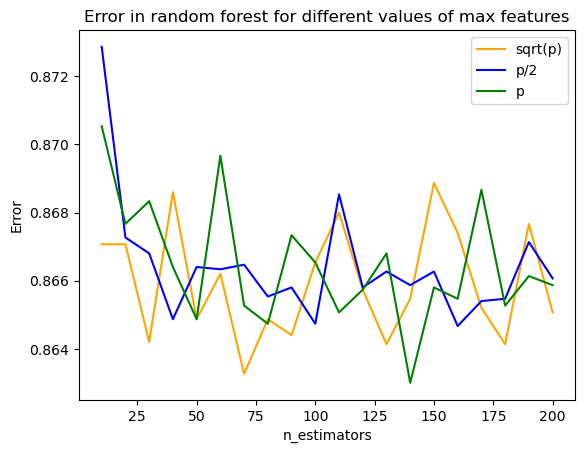

In [ ]:
# If your code above works, below you'll get a plot of the different choices of m
colors = ['orange','blue','green']
labels = ['sqrt(p)', 'p/2', 'p']

for i in range(3):
    M_error = Errors[i]
    plt.plot(n_tree_list, M_error, label = labels[i], color = colors[i])

plt.legend()
plt.title('Error in random forest for different values of max features')
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.show()

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [ ]:
# how did you do it (etc. etc.)

## Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

### discussion on the classification results

### discussion on the regression results

### discussion on the other results

### conclusion and future steps

## Author contribution

_(Please describe the contribution of each member of group)._

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_